<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Pseudo-Spectral Method - Elastic Wave Equation 1D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Initialize the Chebyshev derivative matrix $D_{ij}$ and display the Chebyshev derivative matrix
* Define and initialize space, material and source parameters
* Extrapolate time using the previously defined Chebyshev derivative matrix

**Update May 13, 2020**
* Change naming of fields from p to u to make it compatible with equations
* Added option for mu and ro to be heterogeneous (i.e., now defined as vectors)
* Made space derivative calculations consistent with elastic equation

#### Exercise:

Appreciate the densification of the mesh at the edges. Discuss the consequences.


## Basic Equations
This notebook presents the numerical solution for the 1D elastic wave equation using the Chebyshev Pseudospectral Method. We depart from the equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}

and use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the displacement field is extrapolated as

\begin{equation}
\rho_i\frac{u_{i}^{j+1} - 2u_{i}^{j} + u_{i}^{j-1}}{dt^2}= \partial_x (\mu(x) \partial_x u(x,t))_{i}^{j} + f_{i}^{j}
\end{equation}

An alternative way of performing space derivatives of a function defined on the Chebyshev collocation points is to define a derivative matrix $D_{ij}$

\begin{equation}
D_{ij} =
  \begin{cases}
    -\frac{2 N^2 + 1}{6} \hspace{1.5cm} \text{for  i  = j = N}\\
    -\frac{1}{2} \frac{x_i}{1-x_i^2} \hspace{1.5cm} \text{for i = j = 1,2,...,N-1}\\
    \frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i - x_j} \hspace{1.5cm} \text{for i $\neq$ j = 0,1,...,N}
  \end{cases}
\end{equation}

where $N+1$ is the number of Chebyshev collocation points $ \ x_i = cos(i\pi / N)$, $ \ i=0,...,N$ and the $c_i$ are given as

$$ c_i = 2 \hspace{1.5cm} \text{for  i  = 0 or N} $$
$$ c_i = 1 \hspace{1.5cm} \text{otherwise} $$

This differentiation matrix allows us to write the derivative of the function $f_i = f(x_i)$ (possibly depending on time) simply as

$$\partial_x u_i = D_{ij} \ u_j$$

where the right-hand side is a matrix-vector product, and the Einstein summation convention applies.

### 1. Chebyshev derivative method


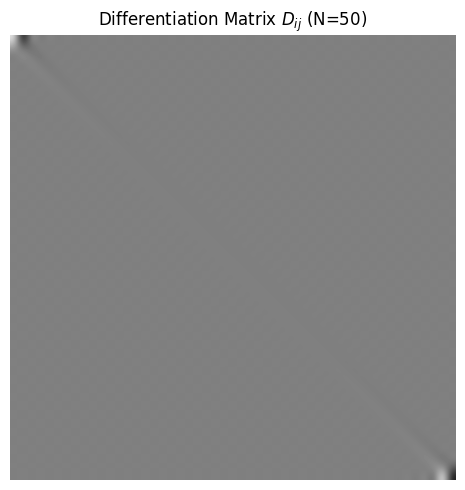

Setup complete. Ricker module and Chebyshev matrix function defined.


In [2]:
# Block 1: Setup, Ricker Fetch, and Chebyshev Function Definition

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import requests
import importlib.util
import sys
import time
from IPython import display
# Use the inline backend for stable Colab plotting
%matplotlib inline

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

# --- Fetch and import the Ricker wavelet function ---
# The GitHub link is provided here as requested:
ricker_url = "https://raw.githubusercontent.com/kboroz/ScientificMachineLearning/refs/heads/main/Week04%20/%20Pseudospectral%20Methods/Notebooks/ricker.py"
response = requests.get(ricker_url)

# Save temporarily
with open("ricker.py", "w") as f:
    f.write(response.text)

# Import it as a module
spec = importlib.util.spec_from_file_location("ricker", "ricker.py")
ricker_module = importlib.util.module_from_spec(spec)
sys.modules["ricker"] = ricker_module
spec.loader.exec_module(ricker_module)

ricker = ricker_module.ricker

# Define Function that initializes the Chebyshev derivative matrix D_{ij}
def get_cheby_matrix(nx):
    """Initializes the Chebyshev derivative matrix D for nx+1 points."""
    x = np.cos(np.pi * np.arange(nx + 1) / nx)

    # c_i values: c_0=2, c_N=2, c_i=1 otherwise
    cx = np.ones(nx + 1)
    cx[0] = 2.
    cx[nx] = 2.

    # Initialize differentiation matrix D
    D = np.zeros((nx+1, nx+1))

    for i in range(0, nx+1):
        for j in range(0, nx+1):
            if i == j:
                if i == 0:
                    D[i, i] = (2.*nx**2 + 1.) / 6.
                elif i == nx:
                    D[i, i] = -D[0, 0] # D_NN = -D_00
                else:
                    D[i, i] = -x[i] / (2.0 * (1.0 - x[i]**2))
            else:
                D[i, j] = (cx[i] / cx[j]) * ((-1.)**(i + j)) / (x[i] - x[j])

    return D, x

# ---------------------------------------------------------------
# Display Differentiation Matrix (Initial check)
# ---------------------------------------------------------------
D_ij, _ = get_cheby_matrix(50)
plt.figure(figsize=(6, 5))
plt.imshow(D_ij, interpolation="bicubic", cmap="gray")
plt.title('Differentiation Matrix $D_{ij}$ (N=50)')
plt.axis("off")
plt.tight_layout()
plt.show()

print("Setup complete. Ricker module and Chebyshev matrix function defined.")

### 2. Initialization of setup

### 3. Source Initialization

In [16]:
# Block 2: Initialization of Parameters and Source

# Basic parameters
# ---------------------------------------------------------------
tmax  = 0.0003    # Seismogram length
eps   = 1.4       # stability limit (Courant number)
isx   = 50        # Index of source location (nx=100, so 50 is center)
f0    = 50000     # dominant frequency
iplot = 20        # Snapshot frequency

# space domain
nx = 100          # number of grid points in x
# xs is the index: xs = 50, but we use isx=50 directly.
x  = np.zeros(nx+1)

# initialization of displacement fields
u = np.zeros(nx+1)
unew = u.copy()
uold = u.copy()
d2u  = u.copy()

# Background elastic parameters
rho0 = 2500.    # kg/m^3
c0 = 3000.     # m/s
mu0 = rho0 * c0**2 # Pa (Shear Modulus)

# material parameters (in vector form, as requested by the update)
rho = np.zeros(nx+1) + rho0
c = np.zeros(nx+1) + c0
mu = np.zeros(nx+1) + mu0

# Initialize spatial domain [-1, 1] using Chebyshev points
for ix in range(0,nx+1):
    x[ix] = np.cos(ix * np.pi / nx)

dxmin = min(np.abs(np.diff(x)))
dxmax = max(np.abs(np.diff(x)))

# Time step calculation
dt = eps * dxmin / np.max(c)    # dt based on min grid spacing
nt = int(round(tmax/dt))        # Number of time steps

# source time function
# ---------------------------------------------------------------
t = np.arange(1, nt+1) * dt
T0 = 1./f0
tmp = ricker(dt, T0)
isrc = tmp
tmp = np.diff(tmp) # Source is the derivative of the Ricker wavelet
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp

# spatial source function (Gaussian at the center)
# ---------------------------------------------------------------
sigma = 1.5 * dxmax
x0 = x[isx] # x-coordinate of the source center
sg = np.exp(-1/sigma**2 * (x - x0)**2)
sg = sg / np.max(sg)

print(f"Simulation parameters: nx={nx}, nt={nt}, dt={dt:.2e} s.")

Simulation parameters: nx=100, nt=1303, dt=2.30e-07 s.


### 4. Time Extrapolation

Now we time extrapolate using the previously defined get_cheby_matrix(nx) method to call the differentiation matrix. The discrete values of the numerical simulation are indicated by dots in the animation, they represent the Chebyshev collocation points. Observe how the wavefield near the domain center is less dense than towards the boundaries.

**Note:** The wavefield is plotted with dots in order to indicate the densification of the grid near the boundaries and the small number of points per wavelength required.  

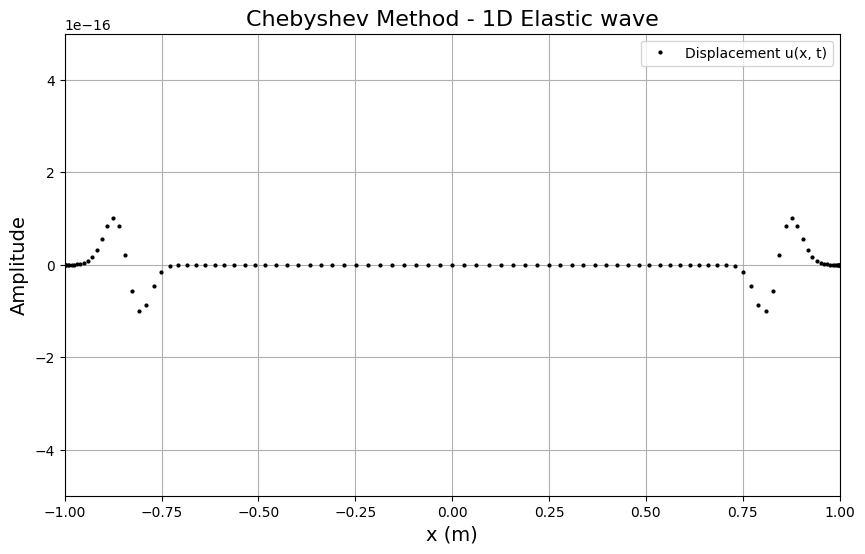

Simulation finished. Final plot displayed.


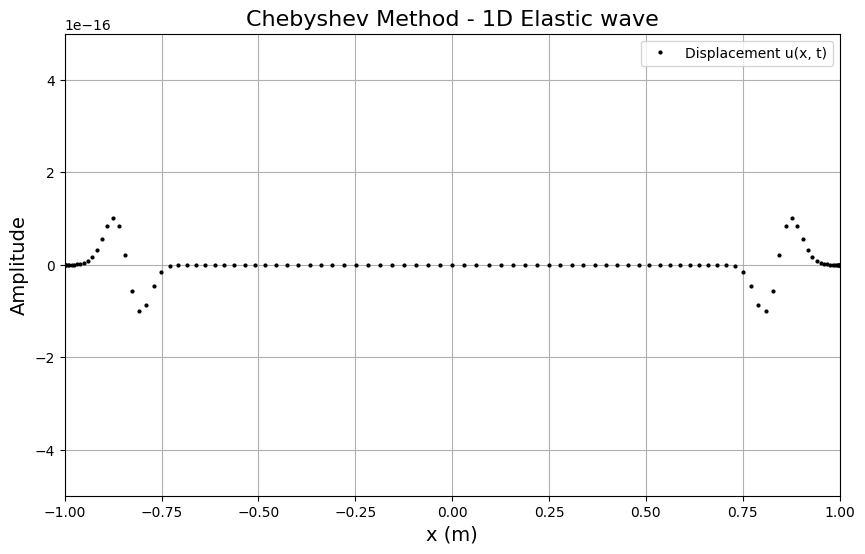

In [17]:
# Block 3: Time Extrapolation and Corrected Animation Loop

# --- Initialization of Plotting ---
plt.figure(figsize=(10,6))
plt.title('Chebyshev Method - 1D Elastic wave', size=16)
plt.xlabel('x (m)', size=14)
plt.ylabel('Amplitude', size=14)
plt.grid(True)
plt.xlim(x[-1], x[0]) # Chebyshev points are typically plotted from -1 to 1
amplitude_limit = 5e-16 # <<< CHANGE HERE
plt.ylim(-amplitude_limit, amplitude_limit)



# Store the Line2D object for efficient update (using comma to unpack)
line, = plt.plot(x, u, 'k.', markersize=4, label='Displacement u(x, t)')
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)
print("Starting time extrapolation loop...")

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
# Differentiation matrix D (only take the matrix, not the x-points)
D = get_cheby_matrix(nx)[0]

for it in range(nt):

    # ----------------------------------------
    # Chebyshev Pseudospectral Space Derivative
    # Term is: (1/rho) * partial_x (mu * partial_x u)
    # ----------------------------------------

    # 1. Calculate shear stress: sigma = mu * partial_x u
    #    (mu * D @ u)
    stress = mu * (D @ u)

    # 2. Calculate partial_x (sigma): partial_x (mu * partial_x u)
    #    (D @ stress)
    d_stress = D @ stress

    # 3. Calculate full spatial term: (1/rho) * partial_x (mu * partial_x u)
    #    (d2u is used to store this for clarity)
    d2u = d_stress / rho


    # ----------------------------------------
    # Time extrapolation (FD 3-point in time)
    # ----------------------------------------
    unew = 2*u - uold + d2u * dt**2

    # Source injection (Note: src is acceleration, so no 1/rho is needed here)
    # Source term is f(x,t) / rho, where f(x,t) = sg * src[it]
    unew = unew + sg * src[it] * dt**2 / rho

    # Remapping
    uold, u = u, unew
    u[0] = 0; u[nx] = 0 # set boundaries to zero displacement (Fixed Boundaries)

    # --------------------------------------
    # Animation plot. Display solution
    # --------------------------------------
    if not it % iplot:
        # Update line data efficiently
        line.set_ydata(u)

        # Force redraw in Colab
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Pause briefly to control animation speed
        time.sleep(0.5)

# Final display
display.clear_output(wait=True)
display.display(plt.gcf())
print("Simulation finished. Final plot displayed.")